In [1]:
import pandas as pd
import seaborn as sns
import umap.umap_ as umap

In [2]:
import sys  
sys.path.insert(0, '/home/m.caros/work/objectDetection/src/model')
from pointnet import ClassificationPointNet


In [3]:
sys.path.insert(0, '/home/m.caros/work/objectDetection/utils')
from utils_plot import plot_3d_coords

In [4]:
from utils_barlow import *

In [5]:
BATCH_SIZE = 1
z_dim=128
use_device = 'cuda'

## Data

In [6]:
dataset_folder = '/dades/LIDAR/towers_detection/datasets/pc_40x40_4096p_v3'
n_points = 4096
c_sample = False

In [7]:
path_list_files='/home/m.caros/work/objectDetection/train_test_files/RGBN_40x40_barlow_p1'

# Datasets train / val / test
with open(os.path.join(path_list_files, 'train_cls_files.txt'), 'r') as f:
    train_files = f.read().splitlines()
with open(os.path.join(path_list_files, 'val_cls_files.txt'), 'r') as f:
    val_files = f.read().splitlines()
with open(os.path.join(path_list_files, 'test_cls_files_no_augm_reduced.txt'), 'r') as f:
    test_files = f.read().splitlines()

# paths_files = glob.glob('/dades/LIDAR/towers_detection/datasets/pc_40x40_4096p/pylon*')
# towers_files = [f.split('/')[-1] for f in paths_files]

In [8]:
# Initialize datasets
test_dataset = BarlowTwinsDataset(dataset_folder=dataset_folder,
                           task='classification', 
                           number_of_points=n_points,
                           files=test_files,
                           fixed_num_points=False,
                           use_ground=True,
                           c_sample=c_sample,
                                 train=False)

In [9]:

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=0, drop_last=False)



## Barlow Twins classifier

### Encoder: PointNet classifier

In [10]:
classifier = ClassificationPointNet(num_classes=2,
                                   point_dimension=3,
                                   dataset=test_dataset,
                                   device=use_device)
classifier = classifier.to(use_device)

pointnet_encoder = classifier.base_pointnet


### Init Barlow Twins model

In [11]:
encoder_out_dim=1024

ckpt_model = BarlowTwins(
    encoder=pointnet_encoder,
    encoder_out_dim=encoder_out_dim,
    num_training_samples=len(test_dataset),
    batch_size=BATCH_SIZE,
    z_dim=z_dim,
)

### Load Barlow Twins trained model

In [12]:
ckpt_dict = torch.load('checkpoints_cls/pretrained_PointNet_4096p_data_augm/epoch=17-step=29592.ckpt')
ckpt_model.load_state_dict(ckpt_dict['state_dict'])
encoder = ckpt_model.encoder.to(use_device)


#### Get embeddings from Barlow Twins for visualization

In [13]:
from tqdm.notebook import tqdm
embed_df = {'embed':[], 'label':[]}

for batch in tqdm(test_loader):
    encoder.eval()
    x1, x2, label = batch
    embed, _ = encoder(x1.to(use_device))
    embed_df['embed'].append(embed.cpu().detach().numpy())
    embed_df['label'].append(label.numpy())
    

  0%|          | 0/430 [00:00<?, ?it/s]

In [14]:
# embed_df['label'] = [label.numpy().item() for label in embed_df['label']]

In [15]:
# embed_df['embed'] = [val.item() for val in embed_df['embed']]

In [16]:
pd.DataFrame(embed_df)

,embed,label
0,"[[2.5854995, 2.3695166, 1.9773256, 2.3625274, ...",[0]
1,"[[2.6263518, 2.4817793, 2.9672973, 2.3107724, ...",[0]
2,"[[1.5985271, 1.5104604, 1.9967184, 1.547413, 2...",[0]
3,"[[2.883023, 1.7470179, 2.4566047, 2.2428665, 3...",[0]
4,"[[2.7688797, 2.5412345, 2.099504, 2.528263, 4....",[0]
...,...,...
425,"[[2.6717196, 1.8433342, 3.1117895, 2.0020444, ...",[1]
426,"[[3.129753, 1.8962251, 3.5352397, 2.226718, 4....",[1]
427,"[[3.389778, 2.158547, 3.1023543, 1.8776038, 2....",[1]
428,"[[2.8733554, 1.8847848, 3.4463673, 2.0616016, ...",[1]


In [17]:
embed_df['embed'] = np.array(embed_df['embed']).reshape(430,1024)

In [18]:
embed_df['embed']

array([[2.5854995, 2.3695166, 1.9773256, ..., 1.2413352, 3.0653636,
        5.22744  ],
       [2.6263518, 2.4817793, 2.9672973, ..., 1.1428723, 2.910803 ,
        4.255149 ],
       [1.5985271, 1.5104604, 1.9967184, ..., 1.2126518, 2.1603527,
        1.2519866],
       ...,
       [3.389778 , 2.158547 , 3.1023543, ..., 1.1471925, 2.8982787,
        3.0204246],
       [2.8733554, 1.8847848, 3.4463673, ..., 1.1156037, 3.2282443,
        4.4639287],
       [3.7299814, 2.0514715, 3.10947  , ..., 1.1294721, 3.2568104,
        3.806322 ]], dtype=float32)

In [19]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(embed_df['embed'])
embedding.shape

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(430, 2)

Text(0.5, 1.0, 'UMAP projection')

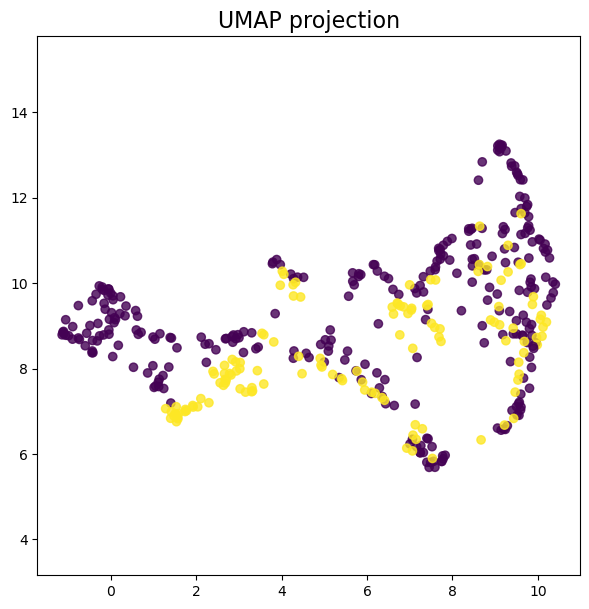

In [20]:
plt.rcParams["figure.figsize"] = (7,7)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    alpha=0.8,
    c=embed_df['label'])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=16)


In [21]:
embed_df['embed'].shape

(430, 1024)

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(embed_df['embed'])
embedding = pca.transform(embed_df['embed'])
embedding.shape

(430, 3)

Text(0.5, 1.0, 'PCA projection')

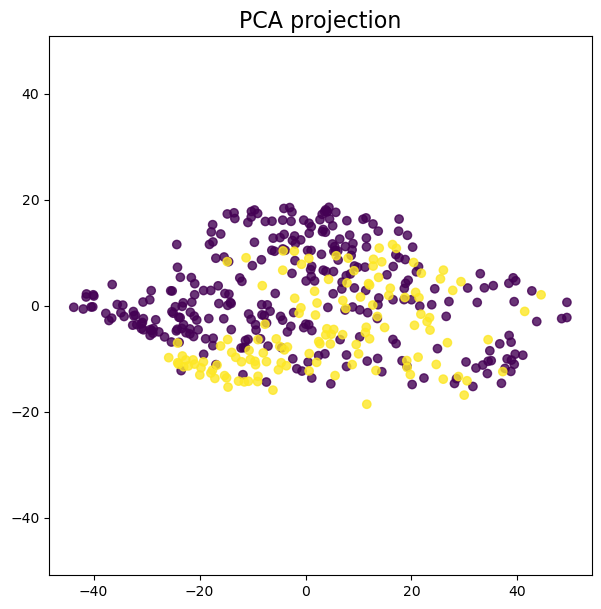

In [23]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    alpha=0.8,
    c=embed_df['label'])
plt.gca().set_aspect('equal', 'datalim')
plt.title('PCA projection', fontsize=16)


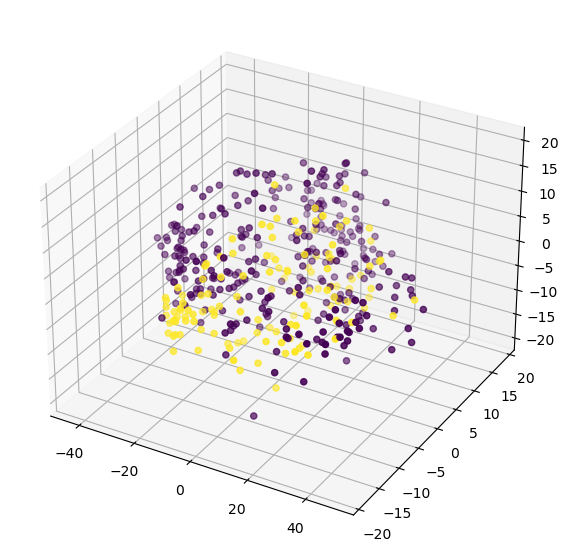

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=embed_df['label'], marker='o')

### Init Simple classifier

In [25]:
cls = Classifier(num_classes=2,
                 encoder=encoder,
                 num_training_samples=len(test_dataset),
                 batch_size=BATCH_SIZE,
                 max_epochs=None,
                 learning_rate=0.001, 
                 dropout=0.3).cuda()


## Test Classifier with Barlow Twins vector

In [26]:
# ckpt_dict = torch.load('checkpoints_tower_cls/epoch=4-step=8220.ckpt')  
# cls.load_state_dict(ckpt_dict['state_dict'])


In [27]:
model = cls.load_from_checkpoint(
    checkpoint_path='checkpoints_tower_cls/epoch=18-step=31236.ckpt',
    hparams_file="lightning_log/sversion_3/hparams.yaml",
    map_location='cuda',
    num_classes=2,
    encoder=encoder,
    num_training_samples=len(test_dataset),
    batch_size=BATCH_SIZE
)


/home/m.caros/anaconda3/envs/pytorch37/lib/python3.7/site-packages/pytorch_lightning/core/saving.py:362: RuntimeWarning: Missing Tags: lightning_log/sversion_3/hparams.yaml.
  rank_zero_warn(f"Missing Tags: {config_yaml}.", category=RuntimeWarning)


In [28]:
len(test_dataset)

430

In [29]:
torch.set_float32_matmul_precision('medium')

In [30]:
# BATCH SIZE = 1
trainer = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None)

# test (pass in the model)
trainer.test(model, dataloaders=test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/m.caros/anaconda3/envs/pytorch37/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         F1_score          │    0.7230046948356806     │
│          ROC AUC          │    0.7861538461538462     │
│       avg_test_acc        │    0.8627907037734985     │
│       avg_test_loss       │    0.32299384474754333    │
└───────────────────────────┴───────────────────────────┘

[{'avg_test_loss': 0.32299384474754333,
  'avg_test_acc': 0.8627907037734985,
  'F1_score': 0.7230046948356806,
  'ROC AUC': 0.7861538461538462}]

In [31]:
# batch=123
for i in range(10, 201):
    if len(test_dataset) % i == 0:
        print(i)

10
43
86
